In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# Data transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
val_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64)

100%|██████████| 170M/170M [00:03<00:00, 48.2MB/s]


In [4]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.to(device)

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)

In [7]:
# Early stopping
best_val_loss = np.inf
patience, trigger_times = 3, 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(20):
    model.train()
    running_loss, correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    train_losses.append(running_loss/len(train_loader))
    train_accs.append(correct / len(train_loader.dataset))

    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            val_correct += (outputs.argmax(1) == labels).sum().item()

    val_losses.append(val_loss/len(val_loader))
    val_accs.append(val_correct / len(val_loader.dataset))

    print(f"Epoch {epoch+1}: Train Acc = {train_accs[-1]*100:.2f}%, Val Acc = {val_accs[-1]*100:.2f}%")

    # Early Stopping
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        torch.save(model.state_dict(), "best_model.pth") # You can change the path to "saved_model/best_model.pth" when running locally
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            break

Epoch 1: Train Acc = 63.30%, Val Acc = 66.99%
Epoch 2: Train Acc = 68.39%, Val Acc = 69.32%
Epoch 3: Train Acc = 72.30%, Val Acc = 71.58%
Epoch 4: Train Acc = 74.85%, Val Acc = 72.46%
Epoch 5: Train Acc = 77.29%, Val Acc = 72.74%
Epoch 6: Train Acc = 79.43%, Val Acc = 73.58%
Epoch 7: Train Acc = 81.13%, Val Acc = 72.71%
Epoch 8: Train Acc = 82.88%, Val Acc = 73.33%
Epoch 9: Train Acc = 84.33%, Val Acc = 72.89%
Early stopping!


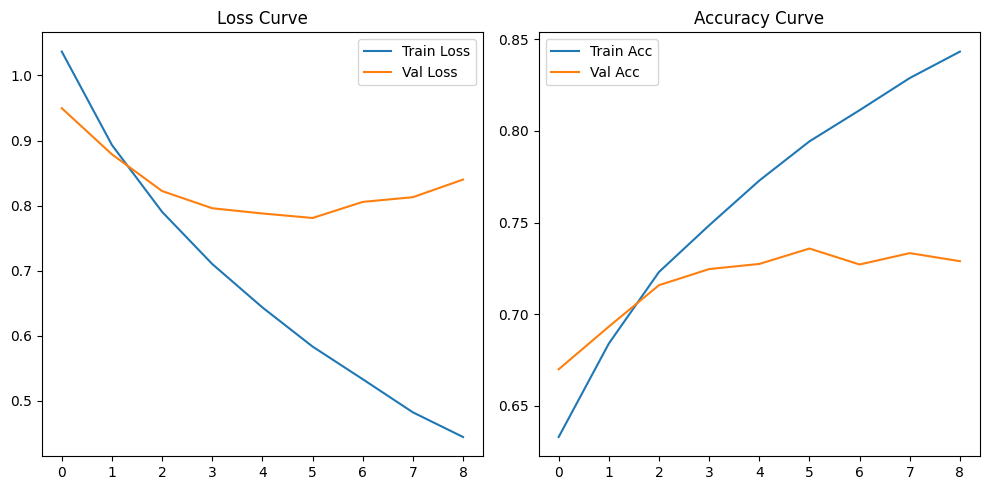

In [8]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.title('Accuracy Curve')

plt.tight_layout()
plt.show()